Chọn phương pháp biến đổi ảnh:
I - Inverse
G - Gamma Correction
L - Log Transformation
H - Histogram Equalization
C - Contrast Stretching


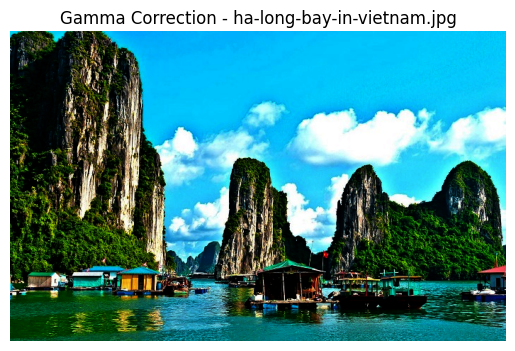

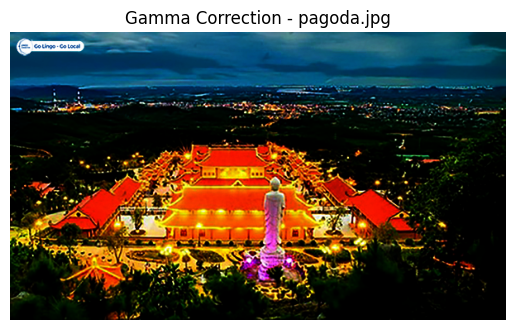

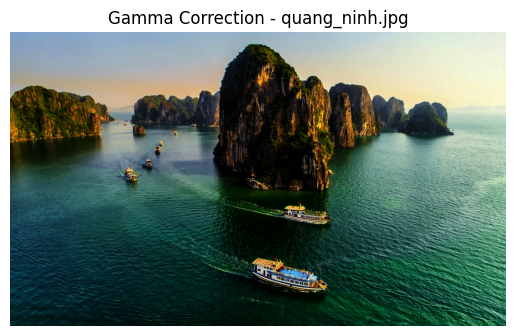

Hoàn tất.


In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 1. Hàm xử lý ảnh màu
def inverse_image(img): return 255 - img
def gamma_correction(img, gamma=2.2): return np.uint8(255 * (img / 255.0) ** gamma)
def log_transformation(img):
    c = 255 / np.log(1 + np.max(img))
    return np.uint8(c * np.log(1 + img.astype(np.float32)))
def histogram_equalization(img):
    result = []
    for i in range(3):
        hist, bins = np.histogram(img[:, :, i].flatten(), 256, [0, 256])
        cdf = hist.cumsum()
        cdf_masked = np.ma.masked_equal(cdf, 0)
        cdf_norm = (cdf_masked - cdf_masked.min()) * 255 / (cdf_masked.max() - cdf_masked.min())
        cdf_final = np.ma.filled(cdf_norm, 0).astype('uint8')
        result.append(cdf_final[img[:, :, i]])
    return np.stack(result, axis=-1)

def contrast_stretching(img):
    result = []
    for i in range(3):
        a, b = np.min(img[:, :, i]), np.max(img[:, :, i])
        stretched = 255 * (img[:, :, i] - a) / (b - a)
        result.append(np.uint8(stretched))
    return np.stack(result, axis=-1)

# 2. Menu
methods = {
    'I': ('Inverse', inverse_image),
    'G': ('Gamma Correction', gamma_correction),
    'L': ('Log Transformation', log_transformation),
    'H': ('Histogram Equalization', histogram_equalization),
    'C': ('Contrast Stretching', contrast_stretching)
}

print("Chọn phương pháp biến đổi ảnh:")
for k, (name, _) in methods.items():
    print(f"{k} - {name}")
choice = input("Nhập lựa chọn (I/G/L/H/C): ").upper()
if choice not in methods:
    print("Lựa chọn không hợp lệ.")
    exit()

method_name, method_function = methods[choice]

input_folder = 'exercise'
output_folder = os.path.join(input_folder, 'output')
os.makedirs(output_folder, exist_ok=True)

count = 0
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.jpg', '.png')):
        input_path = os.path.join(input_folder, filename)
        img = np.array(Image.open(input_path).convert('RGB'))

        if choice == 'G':
            result = method_function(img, gamma=2.2)
        else:
            result = method_function(img)

        output_path = os.path.join(output_folder, f"{choice}_{filename}")
        Image.fromarray(result).save(output_path)

        if count < 5:
            plt.imshow(result)
            plt.title(f"{method_name} - {filename}")
            plt.axis('off')
            plt.show()
        else:
            print(f"Đã xử lý: {filename} -> {choice}_{filename}, kích thước: {img.shape[:2]}")

        count += 1

print("Hoàn tất.")

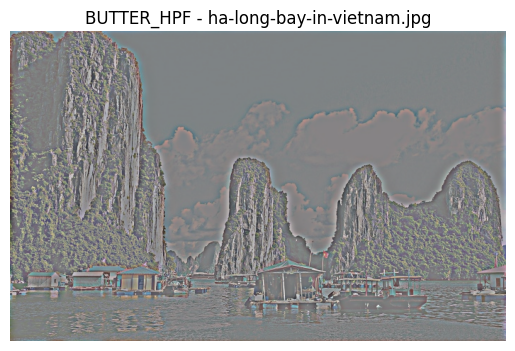

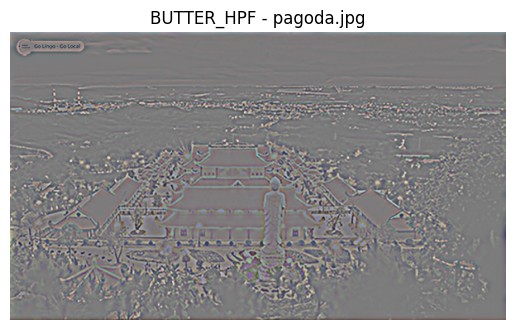

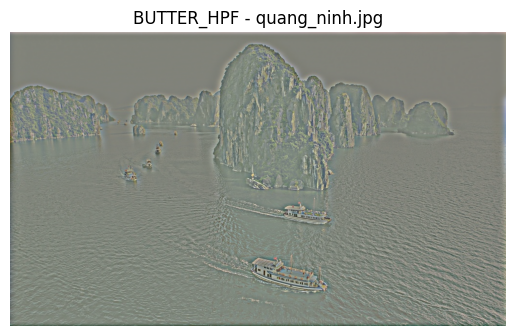

In [7]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def fft_image(img):
    chans = cv2.split(img)
    result = []
    for ch in chans:
        dft = np.fft.fft2(ch)
        dft_shift = np.fft.fftshift(dft)
        mag = 20 * np.log1p(np.abs(dft_shift))
        result.append(cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX))
    return cv2.merge([np.uint8(r) for r in result])

def butterworth_lowpass(img, D0=30, n=2):
    rows, cols = img.shape[:2]
    V, U = np.meshgrid(np.arange(cols) - cols // 2, np.arange(rows) - rows // 2)
    D = np.sqrt(U**2 + V**2)
    H = 1 / (1 + (D / D0)**(2 * n))

    result = []
    for ch in cv2.split(img):
        F = np.fft.fftshift(np.fft.fft2(ch))
        G = H * F
        out = np.fft.ifft2(np.fft.ifftshift(G))
        result.append(cv2.normalize(np.abs(out), None, 0, 255, cv2.NORM_MINMAX))
    return cv2.merge([np.uint8(r) for r in result])

def butterworth_highpass(img, D0=30, n=2):
    low = butterworth_lowpass(img, D0, n)
    high = img.astype(np.float32) - low.astype(np.float32)
    return np.uint8(cv2.normalize(high, None, 0, 255, cv2.NORM_MINMAX))

methods = {
    'F': ('fft', fft_image),
    'L': ('butter_lpf', butterworth_lowpass),
    'H': ('butter_hpf', butterworth_highpass)
}

key = input("Chọn phương pháp (F, L, H): ").upper()
if key not in methods:
    print("Phím không hợp lệ.")
    exit()

name, func = methods[key]
output_folder = os.path.join("exercise", "output")
os.makedirs(output_folder, exist_ok=True)

count = 0
for file in os.listdir("exercise"):
    if file.lower().endswith(('.jpg', '.png')):
        img = cv2.imread(f"exercise/{file}")
        if img is None:
            continue
        out = func(img)
        out_path = os.path.join(output_folder, f"{name}_{file}")
        cv2.imwrite(out_path, out)

        if count < 5:
            plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
            plt.title(f"{name.upper()} - {file}")
            plt.axis('off')
            plt.show()
        else:
            print(f"Đã xử lý: {file} -> {name}_{file}, kích thước: {img.shape[:2]}")
        count += 1

In [1]:
import cv2
import numpy as np
import os
import random

def inverse(img): return 255 - img
def gamma_correction(img, gamma=2.2): return np.uint8(np.power(img / 255.0, 1/gamma) * 255)
def log_transform(img): return np.uint8(np.clip((255 / np.log(1 + np.max(img))) * np.log(1 + img.astype(np.float32)), 0, 255))
def histogram_equalization(img): return cv2.equalizeHist(img)
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    return np.uint8(np.clip((img - p2) * 255.0 / (p98 - p2), 0, 255))

def swap_rgb(img):
    return img[:, :, np.random.permutation(3)]

transform_funcs = [inverse, gamma_correction, log_transform, histogram_equalization, contrast_stretching]
names = ['inverse', 'gamma', 'log', 'hist', 'contrast']

for file in os.listdir("exercise"):
    img = cv2.imread(f"exercise/{file}")
    if img is None: continue

    swapped = swap_rgb(img)
    gray = cv2.cvtColor(swapped, cv2.COLOR_BGR2GRAY)
    
    idx = random.randint(0, 4)
    out = transform_funcs[idx](gray)
    name = names[idx]

    cv2.imwrite(f"exercise/random1_{name}_{file}", out)
    cv2.imshow(f"random1_{name}", out)
    if cv2.waitKey(0) == 27:
        break

cv2.destroyAllWindows()

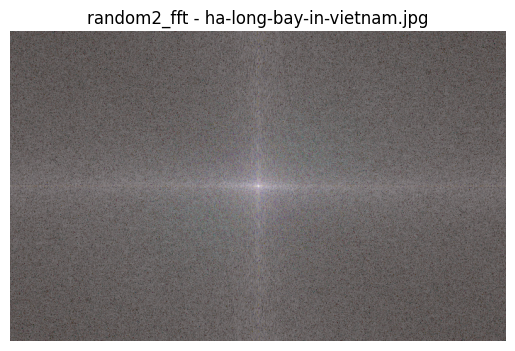

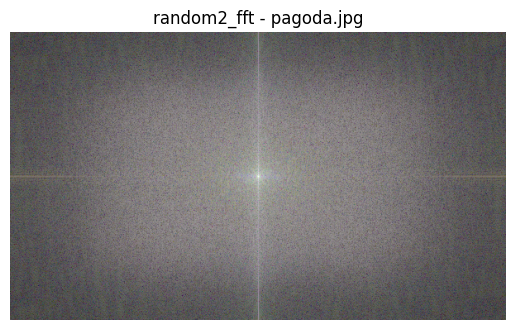

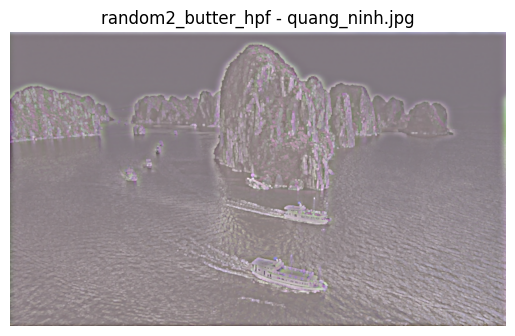

In [8]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt

def fft_image(img):
    chans = cv2.split(img)
    result = []
    for ch in chans:
        dft = np.fft.fft2(ch)
        dft_shift = np.fft.fftshift(dft)
        mag = 20 * np.log1p(np.abs(dft_shift))
        result.append(cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX))
    return cv2.merge([np.uint8(r) for r in result])

def butterworth_lowpass(img, D0=30, n=2):
    rows, cols = img.shape[:2]
    V, U = np.meshgrid(np.arange(cols) - cols // 2, np.arange(rows) - rows // 2)
    D = np.sqrt(U**2 + V**2)
    H = 1 / (1 + (D / D0)**(2 * n))

    result = []
    for ch in cv2.split(img):
        F = np.fft.fftshift(np.fft.fft2(ch))
        G = H * F
        out = np.fft.ifft2(np.fft.ifftshift(G))
        result.append(cv2.normalize(np.abs(out), None, 0, 255, cv2.NORM_MINMAX))
    return cv2.merge([np.uint8(r) for r in result])

def butterworth_highpass(img, D0=30, n=2):
    low = butterworth_lowpass(img, D0, n)
    high = img.astype(np.float32) - low.astype(np.float32)
    return np.uint8(cv2.normalize(high, None, 0, 255, cv2.NORM_MINMAX))

def min_filter(img): return cv2.erode(img, np.ones((3, 3), np.uint8))
def max_filter(img): return cv2.dilate(img, np.ones((3, 3), np.uint8))
def swap_rgb(img): return img[:, :, np.random.permutation(3)]

funcs = [fft_image, butterworth_lowpass, butterworth_highpass]
names = ['fft', 'butter_lpf', 'butter_hpf']

output_folder = os.path.join("exercise", "output")
os.makedirs(output_folder, exist_ok=True)

count = 0
for file in os.listdir("exercise"):
    if file.lower().endswith(('.jpg', '.png')):
        img = cv2.imread(f"exercise/{file}")
        if img is None:
            continue

        swapped = swap_rgb(img)
        idx = random.randint(0, 2)
        out = funcs[idx](swapped)
        name = names[idx]

        if name == 'butter_lpf':
            out = min_filter(out)
        elif name == 'butter_hpf':
            out = max_filter(out)

        out_path = os.path.join(output_folder, f"random2_{name}_{file}")
        cv2.imwrite(out_path, out)

        if count < 5:
            plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
            plt.title(f"random2_{name} - {file}")
            plt.axis('off')
            plt.show()
        else:
            print(f"Đã xử lý: {file} -> random2_{name}_{file}, kích thước: {img.shape[:2]}")
        count += 1